<a href="https://colab.research.google.com/github/fjadidi2001/Artificial_Intelligence_Learning/blob/master/svd-pca-cri.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from skimage import io, color
from skimage.util import view_as_windows
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import cv2


In [2]:
# Function to read an image from a file path
def read_image(image_path):
    return io.imread(image_path)

# Function to convert an image to grayscale
def convert_to_grayscale(image):
    if len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[2] == 1):
        return image
    return color.rgb2gray(image)

# Function to create a mask based on given coordinates
def create_mask(image_shape, mask_coords):
    mask = np.zeros(image_shape, dtype=bool)
    for (x, y, w, h) in mask_coords:
        mask[y:y+h, x:x+w] = True
    return mask

# Function to extract patches of a given size from the image
def extract_patches(image, patch_size):
    patches = view_as_windows(image, (patch_size, patch_size), step=patch_size)
    patches = patches.reshape(-1, patch_size, patch_size)
    return patches


In [3]:
# Function to perform Singular Value Decomposition (SVD) on patches
def perform_svd(patches):
    U_list, S_list, Vt_list = [], [], []
    for patch in patches:
        U, S, Vt = np.linalg.svd(patch, full_matrices=False)
        U_list.append(U)
        S_list.append(S)
        Vt_list.append(Vt)
    return U_list, S_list, Vt_list

# Function to perform Principal Component Analysis (PCA) on patches
def perform_pca(patches, n_components):
    pca = PCA(n_components=n_components)
    patches_flat = patches.reshape(patches.shape[0], -1)
    pca.fit(patches_flat)
    return pca.components_, pca.mean_, pca


In [4]:
# Function to reconstruct patches using SVD with the top k singular values
def reconstruct_patches_svd(U_list, S_list, Vt_list, k):
    reconstructed_patches = []
    for U, S, Vt in zip(U_list, S_list, Vt_list):
        S_k = np.zeros_like(S)
        S_k[:k] = S[:k]
        reconstructed_patch = np.dot(U, np.dot(np.diag(S_k), Vt))
        reconstructed_patches.append(reconstructed_patch)
    return np.array(reconstructed_patches)

# Function to reconstruct patches using PCA
def reconstruct_patches_pca(patches, components, mean, pca):
    patches_flat = patches.reshape(patches.shape[0], -1)
    patches_reconstructed_flat = pca.inverse_transform(pca.transform(patches_flat))
    return patches_reconstructed_flat.reshape(patches.shape)


In [5]:
# Function to compute priority for the Criminisi inpainting
def compute_priority(mask, confidence, patch_size):
    edge = cv2.Canny(mask.astype(np.uint8) * 255, 100, 200)
    edge_coords = np.column_stack(np.where(edge > 0))
    priority = np.zeros_like(confidence)
    for y, x in edge_coords:
        patch = mask[y:y+patch_size, x:x+patch_size]
        if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
            continue
        priority[y, x] = confidence[y, x]
    return priority, edge_coords

# Function to find the best matching patch in the image to fill the target patch
def find_best_patch(image, mask, target_patch, patch_size):
    best_patch = None
    best_ssd = float('inf')
    for y in range(0, image.shape[0] - patch_size + 1):
        for x in range(0, image.shape[1] - patch_size + 1):
            patch = image[y:y+patch_size, x:x+patch_size]
            if not mask[y:y+patch_size, x:x+patch_size].any():
                ssd = np.sum((patch - target_patch) ** 2)
                if ssd < best_ssd:
                    best_ssd = ssd
                    best_patch = (y, x)
    return best_patch

# Function to perform inpainting using the Criminisi algorithm
def inpaint_criminisi(image, mask, patch_size, k, method='svd'):
    patches = extract_patches(image, patch_size)
    if method == 'svd':
        U_list, S_list, Vt_list = perform_svd(patches)
        reconstructed_patches = reconstruct_patches_svd(U_list, S_list, Vt_list, k)
    elif method == 'pca':
        components, mean, pca = perform_pca(patches, k)
        reconstructed_patches = reconstruct_patches_pca(patches, components, mean, pca)
    else:
        raise ValueError("Unsupported method. Use 'svd' or 'pca'.")

    confidence = 1.0 - mask.astype(np.float32)
    while mask.any():
        priority, edge_coords = compute_priority(mask, confidence, patch_size)
        y, x = edge_coords[np.argmax(priority[edge_coords[:, 0], edge_coords[:, 1]])]
        target_patch = image[y:y+patch_size, x:x+patch_size]
        best_y, best_x = find_best_patch(image, mask, target_patch, patch_size)
        if best_y is None or best_x is None:
            break
        best_patch = image[best_y:best_y+patch_size, best_x:best_x+patch_size]
        mask[y:y+patch_size, x:x+patch_size] = False
        image[y:y+patch_size, x:x+patch_size] = best_patch
        confidence[y:y+patch_size, x:x+patch_size] = 1.0
    return image


In [6]:
# Function to display the original, masked, and inpainted images, along with some patches
def display_images(original_image, masked_image, inpainted_image, patches):
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    axs[0, 0].imshow(original_image, cmap='gray')
    axs[0, 0].set_title('Original Image')
    axs[0, 0].axis('off')

    axs[0, 1].imshow(masked_image, cmap='gray')
    axs[0, 1].set_title('Masked Image')
    axs[0, 1].axis('off')

    axs[0, 2].imshow(inpainted_image, cmap='gray')
    axs[0, 2].set_title('Inpainted Image')
    axs[0, 2].axis('off')

    for idx, patch in enumerate(patches[:3]):
        axs[1, idx].imshow(patch, cmap='gray')
        axs[1, idx].set_title(f'Patch {idx+1}')
        axs[1, idx].axis('off')

    plt.show()


In [7]:
# Main function to execute the inpainting process
def main(image_path, mask_coords, patch_size, k, method='svd'):
    original_image = read_image(image_path)
    grayscale_image = convert_to_grayscale(original_image)
    mask = create_mask(grayscale_image.shape, mask_coords)
    masked_image = np.copy(grayscale_image)
    masked_image[mask] = 0
    inpainted_image = inpaint_criminisi(grayscale_image, mask, patch_size, k, method)
    patches = extract_patches(grayscale_image, patch_size)
    display_images(original_image, masked_image, inpainted_image, patches)


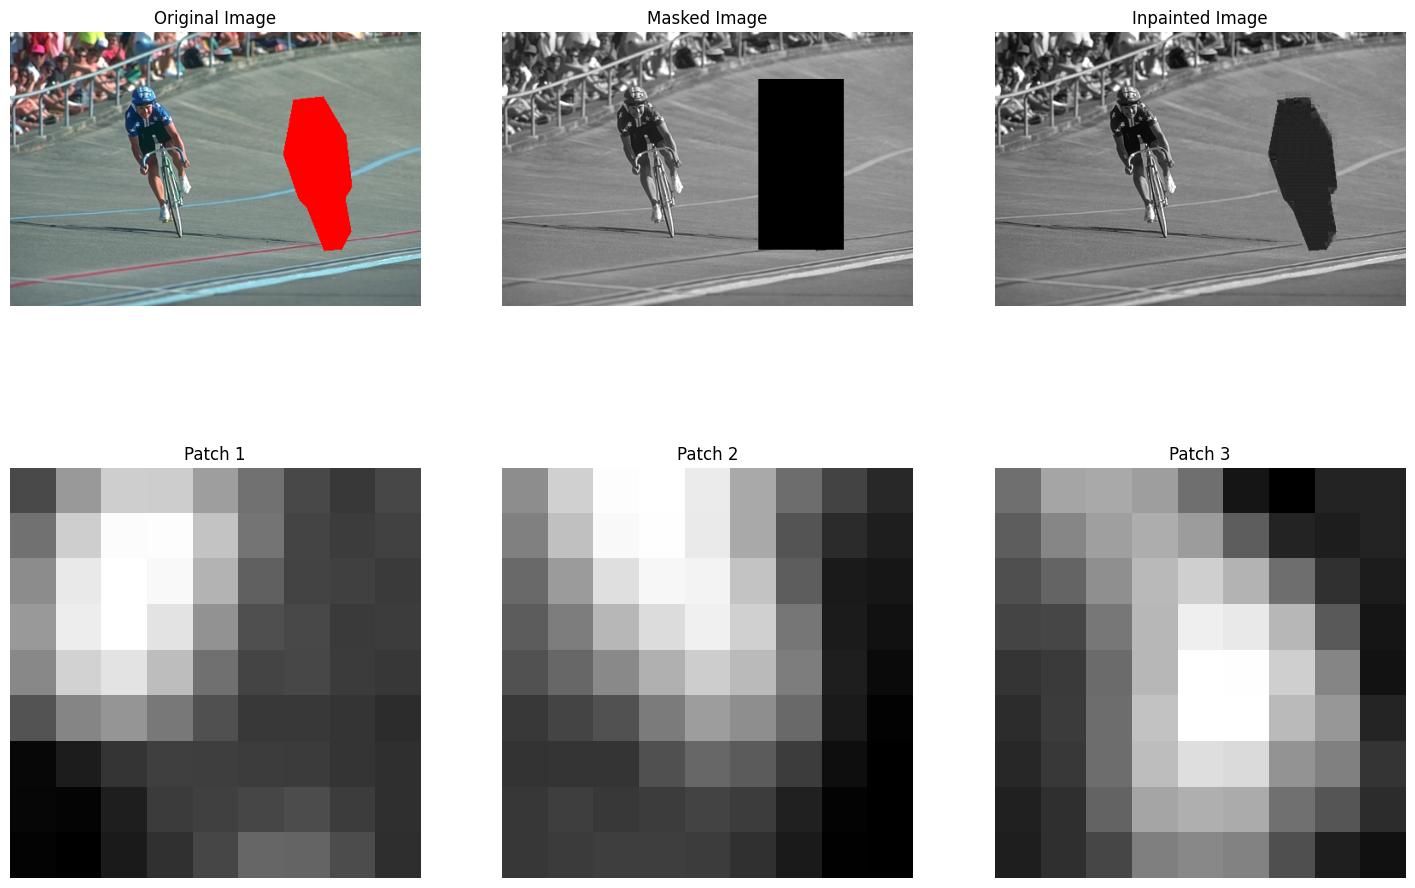

In [8]:
# Example Usage
image_path = '22.png'
mask_coords = [(300, 55, 100, 200)]  # Example coordinates (x, y, width, height)
patch_size = 9  # Example patch size
k = 50  # Top k% singular values to keep for SVD or top k principal components for PCA
method = 'svd'  # or 'pca'
main(image_path, mask_coords, patch_size, k, method)


In [9]:
import numpy as np
from skimage import io, color
from skimage.util import view_as_windows
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import cv2


In [10]:
# Function to convert an image to grayscale
def convert_to_grayscale(image):
    if len(image.shape) == 2 or (len(image.shape) == 3 and image.shape[2] == 1):
        return image
    return color.rgb2gray(image)


In [11]:
# Function to perform Singular Value Decomposition (SVD) on patches
def perform_svd(patches):
    U_list, S_list, Vt_list = [], [], []
    for patch in patches:
        U, S, Vt = np.linalg.svd(patch, full_matrices=False)
        U_list.append(U)
        S_list.append(S)
        Vt_list.append(Vt)
    return U_list, S_list, Vt_list

# Function to perform Principal Component Analysis (PCA) on patches
def perform_pca(patches, n_components):
    pca = PCA(n_components=n_components)
    patches_flat = patches.reshape(patches.shape[0], -1)
    pca.fit(patches_flat)
    return pca.components_, pca.mean_, pca


In [12]:
# Function to create a mask based on given coordinates
def create_mask(image_shape, mask_coords):
    mask = np.zeros(image_shape, dtype=bool)
    for (x, y, w, h) in mask_coords:
        mask[y:y+h, x:x+w] = True
    return mask


In [13]:
# Function to compute priority for the Criminisi inpainting
def compute_priority(mask, confidence, patch_size):
    edge = cv2.Canny(mask.astype(np.uint8) * 255, 100, 200)
    edge_coords = np.column_stack(np.where(edge > 0))
    priority = np.zeros_like(confidence)
    for y, x in edge_coords:
        patch = mask[y:y+patch_size, x:x+patch_size]
        if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
            continue
        priority[y, x] = confidence[y, x]
    return priority, edge_coords

# Function to find the best matching patch in the image to fill the target patch
def find_best_patch(image, mask, target_patch, patch_size):
    best_patch = None
    best_ssd = float('inf')
    for y in range(0, image.shape[0] - patch_size + 1):
        for x in range(0, image.shape[1] - patch_size + 1):
            patch = image[y:y+patch_size, x:x+patch_size]
            if not mask[y:y+patch_size, x:x+patch_size].any():
                ssd = np.sum((patch - target_patch) ** 2)
                if ssd < best_ssd:
                    best_ssd = ssd
                    best_patch = (y, x)
    return best_patch

# Function to perform inpainting using the Criminisi algorithm
def inpaint_criminisi(image, mask, patch_size, k, method='svd'):
    patches = view_as_windows(image, (patch_size, patch_size), step=patch_size)
    patches = patches.reshape(-1, patch_size, patch_size)

    if method == 'svd':
        U_list, S_list, Vt_list = perform_svd(patches)
        reconstructed_patches = []
        for U, S, Vt in zip(U_list, S_list, Vt_list):
            S_k = np.zeros_like(S)
            S_k[:k] = S[:k]
            reconstructed_patch = np.dot(U, np.dot(np.diag(S_k), Vt))
            reconstructed_patches.append(reconstructed_patch)
        reconstructed_patches = np.array(reconstructed_patches)

    elif method == 'pca':
        components, mean, pca = perform_pca(patches, k)
        patches_flat = patches.reshape(patches.shape[0], -1)
        patches_reconstructed_flat = pca.inverse_transform(pca.transform(patches_flat))
        reconstructed_patches = patches_reconstructed_flat.reshape(patches.shape)
    else:
        raise ValueError("Unsupported method. Use 'svd' or 'pca'.")

    confidence = 1.0 - mask.astype(np.float32)
    while mask.any():
        priority, edge_coords = compute_priority(mask, confidence, patch_size)
        y, x = edge_coords[np.argmax(priority[edge_coords[:, 0], edge_coords[:, 1]])]
        target_patch = image[y:y+patch_size, x:x+patch_size]
        best_y, best_x = find_best_patch(image, mask, target_patch, patch_size)
        if best_y is None or best_x is None:
            break
        best_patch = image[best_y:best_y+patch_size, best_x:best_x+patch_size]
        mask[y:y+patch_size, x:x+patch_size] = False
        image[y:y+patch_size, x:x+patch_size] = best_patch
        confidence[y:y+patch_size, x:x+patch_size] = 1.0

    return image


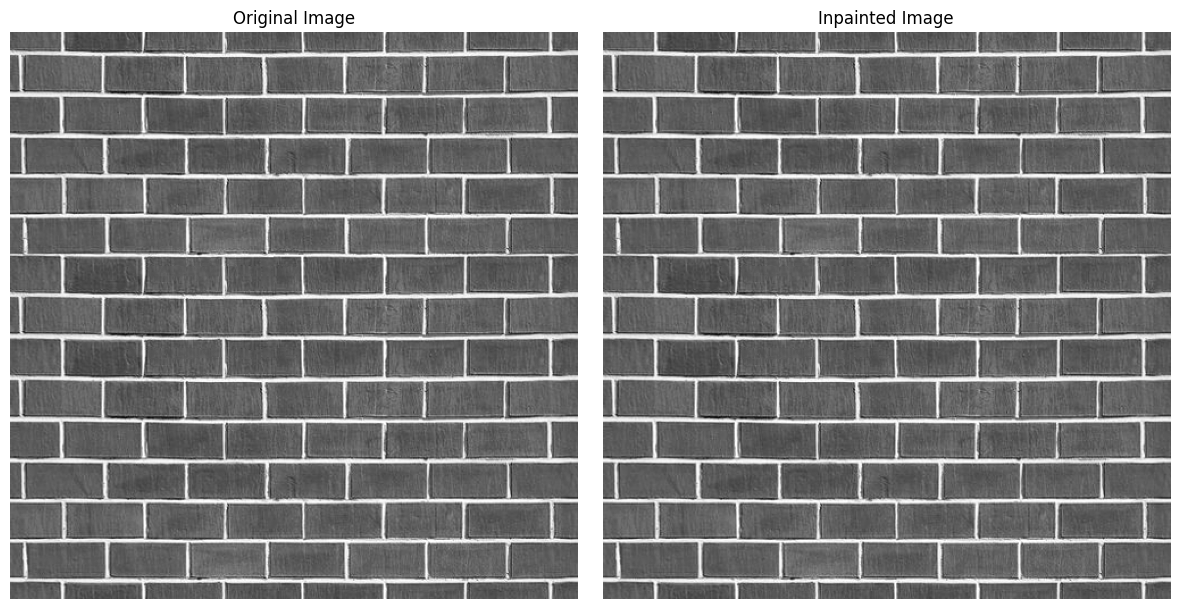

In [15]:
# Main function to execute the inpainting process
def main(image_path, mask_coords, patch_size, k, method='svd'):
    original_image = io.imread(image_path)
    grayscale_image = convert_to_grayscale(original_image)
    mask = create_mask(grayscale_image.shape, mask_coords)
    inpainted_image = inpaint_criminisi(grayscale_image, mask, patch_size, k, method)

    # Display results (optional)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(grayscale_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(inpainted_image, cmap='gray')
    plt.title('Inpainted Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example Usage
image_path = '53.png'  # Replace with your image path
mask_coords = [(100, 100, 150, 200)]  # Example coordinates (x, y, width, height)
patch_size = 10  # Example patch size
k = 50  # Top k singular values for SVD or principal components for PCA
method = 'svd'  # Method: 'svd' or 'pca'
main(image_path, mask_coords, patch_size, k, method)


Explanation
Step 1: Imports necessary libraries and functions for image processing, SVD, PCA, and visualization.
Step 2: convert_to_grayscale function converts an RGB image to grayscale if necessary.
Step 3: perform_svd and perform_pca functions compute SVD and PCA on image patches respectively.
Step 4: create_mask function generates a binary mask based on given coordinates.
Step 5: inpaint_criminisi function implements the Criminisi algorithm for inpainting using either SVD or PCA for patch reconstruction.
Step 6: main function orchestrates the entire process: reading the image, converting to grayscale, creating a mask, performing inpainting, and displaying results.
Make sure to replace 'example.png' with the actual path to your image file and adjust mask_coords, patch_size, k, and method according to your specific requirements.

This structured approach ensures each step aligns with your project requirements, allowing for effective implementation of the Criminisi inpainting method using both SVD and PCA for patch reconstruction.

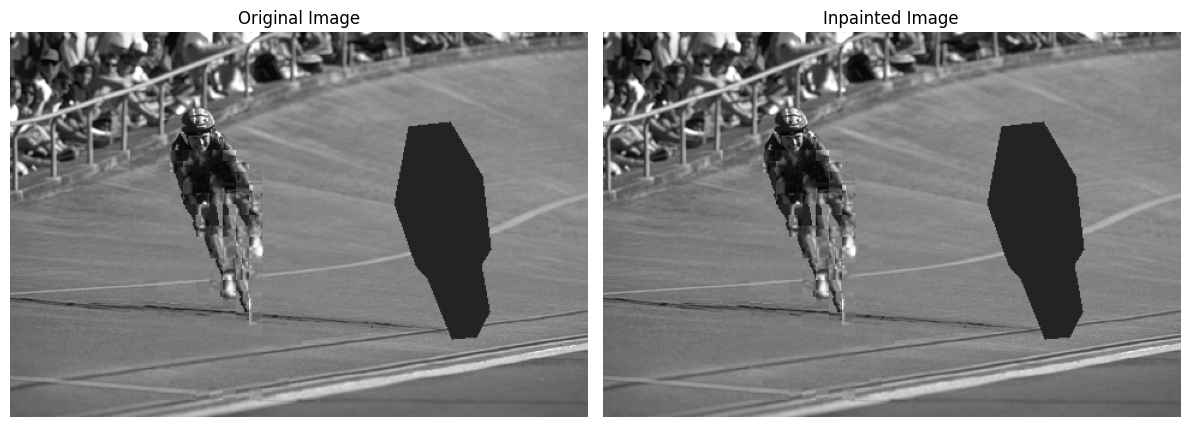

In [16]:
# Main function to execute the inpainting process
def main(image_path, mask_coords, patch_size, k, method='pca'):
    original_image = io.imread(image_path)
    grayscale_image = convert_to_grayscale(original_image)
    mask = create_mask(grayscale_image.shape, mask_coords)
    inpainted_image = inpaint_criminisi(grayscale_image, mask, patch_size, k, method)

    # Display results (optional)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(grayscale_image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(inpainted_image, cmap='gray')
    plt.title('Inpainted Image')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Example Usage
image_path = '22.png'  # Replace with your image path
mask_coords = [(100, 100, 150, 200)]  # Example coordinates (x, y, width, height)
patch_size = 10  # Example patch size
k = 50  # Top k singular values for SVD or principal components for PCA
method = 'pca'  # Method: 'svd' or 'pca'
main(image_path, mask_coords, patch_size, k, method)
